In [1]:
import torch
import time
import matplotlib.pyplot as plt
import non_local_boxes

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1. Basic Gradient Descent

## 1.1. Constraint => Projection

As we maximize under constraints, we need the orthogonal projection onto the unit hypercube $[0,1]^{32}$:

In [2]:
# def projected_wiring_basic(W):  # W is a 32xn tensor
#     W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
#     W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum
#     return W

In [3]:
# def projected_wiring_old(W):  # W is a 32xn tensor
#     W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
#     W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

#     # Then we verify the 4 equalities of (5)
#     for alpha in range(non_local_boxes.evaluate.nb_columns):
#         #1
#         if abs(W[0, alpha] - W[1, alpha]) <= abs(W[8, alpha] - W[9, alpha]):
#             W[0, alpha] = (W[0, alpha]+W[1, alpha])/2
#             W[1, alpha] = W[0, alpha]
#         else:
#             W[8, alpha] = (W[8, alpha]+W[9, alpha])/2
#             W[9, alpha] = W[8, alpha]
            
#         #2
#         if abs(W[2, alpha] - W[3, alpha]) <= abs(W[10, alpha] - W[11, alpha]):
#             W[2, alpha] = (W[2, alpha]+W[3, alpha])/2
#             W[3, alpha] = W[2, alpha]
#         else:
#             W[10, alpha] = (W[10, alpha]+W[11, alpha])/2
#             W[11, alpha] = W[10, alpha]
            
#         #3
#         if abs(W[4, alpha] - W[5, alpha]) <= abs(W[12, alpha] - W[13, alpha]):
#             W[4, alpha] = (W[4, alpha]+W[5, alpha])/2
#             W[5, alpha] = W[4, alpha]
#         else:
#             W[12, alpha] = (W[12, alpha]+W[13, alpha])/2
#             W[13, alpha] = W[12, alpha]
                
#         #4
#         if abs(W[6, alpha] - W[7, alpha]) <= abs(W[14, alpha] - W[15, alpha]):
#             W[6, alpha] = (W[6, alpha]+W[7, alpha])/2
#             W[7, alpha] = W[6, alpha]
#         else:
#             W[14, alpha] = (W[14, alpha]+W[15, alpha])/2
#             W[15, alpha] = W[14, alpha]

#     return W

In [4]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5


In [5]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    # If T1[i] is True: W[:,i] becomes M1 . W[:,i]
    # Otherwise: W[:,i] becomes M2 . W[:,i]
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    # If T2[i] is True: W[:,i] becomes M3 . W[:,i]
    # Otherwise: W[:,i] becomes M4 . W[:,i]
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    # If T3[i] is True: W[:,i] becomes M5 . W[:,i]
    # Otherwise: W[:,i] becomes M6 . W[:,i]
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    # If T4[i] is True: W[:,i] becomes M7 . W[:,i]
    # Otherwise: W[:,i] becomes M8 . W[:,i]
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [6]:
# W = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns).detach()
# projected_wiring(W) == projected_wiring_old(W)

In [7]:
W = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
P = non_local_boxes.utils.SR
Q = non_local_boxes.utils.PR
float(non_local_boxes.evaluate.phi_flat(W, P, Q)[0])

0.875

## 1.2. Gradient Descent

In [2]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_iterations = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

In [13]:
# Initialization
starting_W = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)
P = non_local_boxes.utils.SR
Q = non_local_boxes.utils.PR
learning_rate = 2
nb_iterations = 20


# Gradient Descent
print("(Iterating...)")
tic = time.time()
W = gradient_descent(starting_W, P, Q, learning_rate, nb_iterations)
toc = time.time()


# Result
list = non_local_boxes.evaluate.phi_flat(W, P, Q).detach().numpy()
print("")
print("Number of tested wirings: ", len(list))
print("--> Min:    ", min(list))
print("--> Av.:    ", sum(list)/len(list))
index, value = max(enumerate(list), key=lambda x: x[1])
best_wiring = W[:,index].detach().numpy()
print("--> Max:    ", value)
print("Duration: ", (toc-tic)*1e0, "s")
print("")
print("-----")
print("The best wiring is:\n", best_wiring)
print("-----")
non_local_boxes.utils.wiring_to_functions(best_wiring)

(Iterating...)

Number of tested wirings:  1000
--> Min:     0.74737376
--> Av.:     0.7902006754279136
--> Max:     1.0
Duration:  0.3158600330352783 s

-----
The best wiring is:
 [0.32223618 0.02889622 0.42890984 0.42890984 0.2155349  0.2155349
 0.3752831  0.3752831  0.         0.         1.         1.
 0.         1.         1.         0.         1.         0.
 0.         1.         1.         0.         1.         0.
 1.         0.         0.         1.         1.         0.
 0.         1.        ]
-----
f_1(x,a2) =  0.10667365789413452 x ⊕  1.7066600322723389 a2 ⊕  0.29333996772766113 x*a2 ⊕  0.32223618030548096
g_1(y,b2) =  0.15974819660186768 y ⊕  0.0 b2 ⊕  0.0 y*b2 ⊕  0.21553489565849304
f_2(x,a1) =  1.0 x ⊕  0.0 a1 ⊕  0.0 x*a1 ⊕  0.0
g_2(y,b1) =  1.0 y ⊕  1.0 b1 ⊕  0.0 y*b1 ⊕  0.0
f_3(x,a1,a2) =  0.0 x ⊕  1.0 a1 ⊕  1.0 a2 ⊕  0.0 x*a1 ⊕  1.0 x*a2 ⊕  0.0 a1*a2 ⊕  0.0 x*a1*a2 ⊕  1.0
g_3(y,b1,b2) =  0.0 y ⊕  1.0 b1 ⊕  1.0 b2 ⊕  0.0 y*b1 ⊕  0.0 y*b2 ⊕  0.0 b1*b2 ⊕  0.0 y*b1*b2 ⊕  1.

In [11]:
#assert(False)

In [ ]:
# [0.24272715, 0.12160056, 0.9498826 , 0.02322189, 0.39412087,
#        0.39412087, 0.83709   , 0.52627677, 0.        , 0.        ,
#        1.        , 1.        , 0.        , 0.        , 1.        ,
#        1.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        , 1.        , 0.        , 1.        ,
#        0.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        ]

In [ ]:
# W = torch.t(torch.tensor([[0., 0., 1. , 0., 0.,
#        0., 1.   , 0.5 , 0.        , 0.        ,
#        1.        , 1.        , 0.        , 0.        , 1.        ,
#        1.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        , 1.        , 0.        , 1.        ,
#        0.        , 1.        , 0.        , 1.        , 0.        ,
#        1.        , 0.        ]]))

# P = non_local_boxes.utils.SR
# Q = non_local_boxes.utils.PR
# float(non_local_boxes.evaluate.phi_flat(W, P, Q)[0])

## 1.3 Test in the triangle PR-P0-P1

0.7500001
0.74997735
0.74999017
0.75000006
0.75
0.7500001
0.7500002
0.7500002
0.7500002
0.7500001
0.7500001
0.7500002
0.7500001
0.7500001
0.7500001
0.7500001
0.7500002
0.7500001
0.7500001
0.75000006
0.75000006
0.7500001
0.7500001
0.7500001
0.7500002
0.7500001
0.75000006
0.7500001
0.7500001
0.7500002
0.7500002
0.7500001
0.7500002
0.7500001
0.7500002
0.7500001
0.7500001
0.7500002
0.7500001
0.7500002
0.7500001
0.7589674
0.75858784
0.75821334
0.75784516
0.7574829
0.75712734
0.756778
0.7564356
0.7560993
0.7557695
0.7554458
0.7551277
0.7548154
0.7545104
0.75421315
0.7539233
0.75364083
0.7533659
0.7530981
0.7528379
0.752585
0.7523392
0.7523076
0.75246674
0.75258243
0.7526038
0.7525166
0.75245714
0.752622
0.7527447
0.75289214
0.7530706
0.75325954
0.7534554
0.753657
0.7538884
0.75414515
0.7544079
0.75467646
0.7549509
0.7737487
0.7730672
0.7723552
0.7716335
0.77090776
0.7701582
0.7694079
0.76866037
0.7677846
0.7668717
0.76598656
0.76507664
0.76415086
0.7632587
0.7623994
0.7615725
0.7607777
0.760

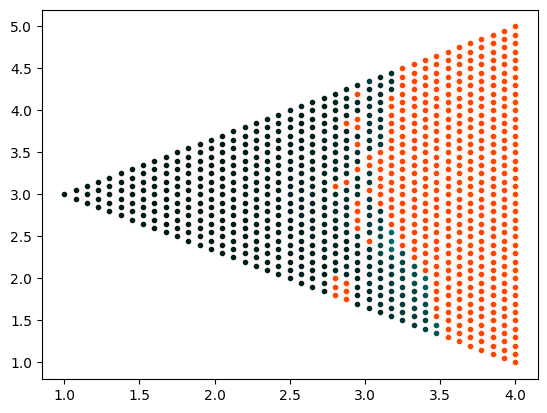

In [6]:
#plt.ion()

X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()

triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
box_grid_size = 40
max_box_power = 50

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_1
#W_BS09 = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
W_random = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)

for i in range(box_grid_size+1):
    for j in range(box_grid_size-i+1):
        alpha = i/box_grid_size
        beta = j/box_grid_size
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        # Given a box P, we look for the W maximizing P x_W P
        W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
        list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        print(value)
        
        Q=torch.clone(P)
        Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 
        for k in range(max_box_power+1):
            if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                break
            #Q2=Q.copy()
            Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()

## Gradient Descent of $W\mapsto P^{\boxtimes_W N}$: not very efficient

In [ ]:
assert(False)

In [107]:
def gradient_descent_power(starting_W, P, N, learning_rate = 2, nb_iterations = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        evaluate = non_local_boxes.evaluate.phi_power_recursive(W, P, N)
        evaluate.backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

>À faire : il faut modifier phi_power et mettre des noms différents pour les Q, sinon l'algo ne retrouve pas les gradients...

In [109]:
n = non_local_boxes.evaluate.nb_columns
W = non_local_boxes.utils.random_wiring(n)
P = non_local_boxes.utils.corNLB(0.5)
gradient_descent_power(W, P, 5, 2, 20)

# external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
# Q2 = non_local_boxes.evaluate.R(W, P, P)
# Q3 = torch.zeros(2, 2, 2, 2, n)
# for alpha in range(n):
#     Q3[:,:,:,:,alpha] = non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q2[:,:,:,:,alpha]), P)[:,:,:,:,alpha]
# non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q3[:,:,:,:,0]), P).backward(gradient=external_grad)
# W.grad



# external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
# Q = torch.clone(P)
# Q = non_local_boxes.utils.matrix_to_tensor(Q) # Q is a 2x2x2x2 tensor
# Q = non_local_boxes.evaluate.R(W, P, P) # Now on, Q is a 2x2x2x2xn tensor
# non_local_boxes.evaluate.h_flat(Q).backward(gradient=external_grad)
# W.grad


tensor([[5.3796e-01, 6.3975e-01, 3.4722e-01],
        [5.3796e-01, 9.9437e-01, 4.9685e-02],
        [8.1197e-02, 3.8734e-01, 8.2044e-01],
        [6.3846e-01, 3.8734e-01, 8.2044e-01],
        [5.9240e-01, 3.2133e-01, 8.8370e-01],
        [2.4215e-01, 3.2133e-01, 8.8370e-01],
        [7.2783e-01, 4.4805e-01, 7.8740e-02],
        [7.2783e-01, 4.4805e-01, 2.7871e-01],
        [6.0542e-02, 9.0961e-02, 7.2724e-01],
        [9.1643e-01, 9.0961e-02, 7.2724e-01],
        [9.1239e-01, 2.2716e-01, 8.6881e-01],
        [9.1239e-01, 7.3677e-01, 0.0000e+00],
        [2.0200e-01, 3.5826e-01, 3.9484e-01],
        [2.0200e-01, 9.9829e-01, 2.1770e-01],
        [5.2329e-01, 0.0000e+00, 6.8893e-01],
        [1.0000e+00, 0.0000e+00, 6.8893e-01],
        [1.0000e+00, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.8149e-01, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 4.5484e-02],
        [1.0000e+00, 3.5666e-01, 0.0000e+00],
        [6.7878e-01, 3.5112e-01, 1.0000e+00],
        [5.9157e-03, 1.0000e+00, 1

In [103]:
n = non_local_boxes.evaluate.nb_columns
W = non_local_boxes.utils.W_BS09(n)
P = non_local_boxes.utils.corNLB(0.5)
print(non_local_boxes.evaluate.phi_power_recursive(W, P, 3))
Q = non_local_boxes.evaluate.R(W, P, P)[:,:,:,:,0]
Q = non_local_boxes.utils.tensor_to_matrix(Q)
print(non_local_boxes.evaluate.phi_flat(W, Q, P))

tensor([0.9297, 0.9297, 0.9297], grad_fn=<ReshapeAliasBackward0>)
tensor([0.9297, 0.9297, 0.9297], grad_fn=<ReshapeAliasBackward0>)


Gradient Descent for each power:

tensor(0.7500)
0.7500001


KeyboardInterrupt: 

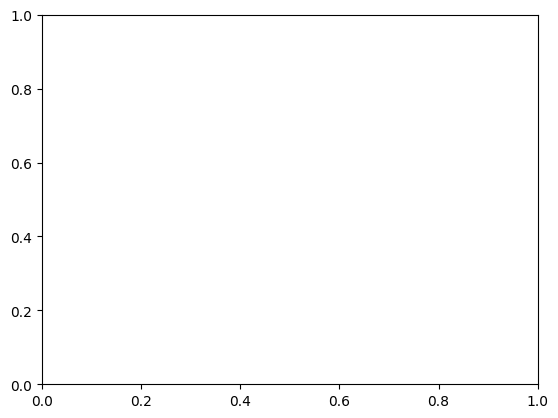

In [118]:
X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()

triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
box_grid_size = 10
max_box_power = 2

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_1
W_random = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)

for i in range(box_grid_size+1):
    for j in range(box_grid_size-i+1):
        alpha = i/box_grid_size
        beta = j/box_grid_size
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        
        #Q=torch.clone(P)
        #Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 

        value = non_local_boxes.evaluate.h_flat(non_local_boxes.utils.matrix_to_tensor(P))[0]
        print(value)
        
        for k in range(1, max_box_power+1):

            if value > threshold:
                color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                break

            W = gradient_descent_power(W_random, P, k+1, learning_rate=2, nb_iterations=20)
            list = non_local_boxes.evaluate.phi_power_recursive(W, P, k+1).detach().numpy()
            index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
            #best_wiring = W[:,index].detach()
            #best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
            print(value)
            #Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()

> Coder à la main les puissances jusqu'à 10

# Puissances à la main

In [87]:
def new_color(value, threshold, k, max_box_power_GD):
    if value > threshold:
        return (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return "orangered"

In [88]:
def next_Q(Q, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        color_point = new_color(value, threshold, k, max_box_power_GD)
        print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, color_point

In [114]:
def test_box_power(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        color_point = new_color(value, threshold, k, max_box_power_GD)

    return color_point


0.75
0.7499999
0.7499999
0.74999976
0.74885076
0.74685675
0.7499995
0.7499999
0.7499352
0.7500001
0.7500001
0.7500001
0.7500001
0.74695903
0.75000006
0.75
0.7500001
0.7487983
0.7500001
0.7500002
0.75
0.7499999
0.75
0.75
0.7500001
0.7500002
0.7500002
0.7500003
0.75000006
0.75
0.75
0.75000006
0.75000006
0.74884516
0.7499744
0.74999845
0.74940836
0.7457508
0.74923944
0.7499999
0.75
0.75
0.75
0.74999994
0.7578605
0.771842
0.77342105
0.77349603
0.74871314
0.75691587
0.7673734
0.7714004
0.7497975
0.7455897
0.751691
0.7516011
0.7489489
0.7184935
0.74747854
0.74937534
0.74949765
0.74912924
0.7500001
0.75000006
0.74890876
0.74972445
0.74991083
0.74996626
0.74996835
0.74907583
0.7500003
0.7500003
0.75000006
0.74835813
0.74944204
0.7498175
0.7463633
0.74471813
0.7489753
0.7516036
0.75014967
0.7505031
0.75582045
0.7695181
0.7920341
0.78522974
0.78100353
0.77736807
0.7876539
0.7775311
0.7823788
0.7868174
0.75605536
0.74484336
0.7412551
0.74008757
0.7528071
0.758383
0.77044415
0.78109133
0.77237
0.7

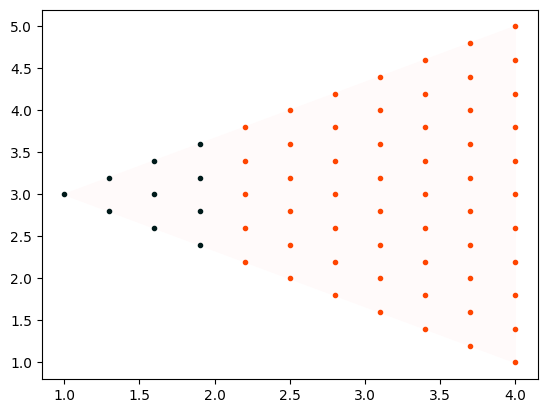

In [118]:
X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

# constants
threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
box_grid_size = 10
max_box_power = 50
max_box_power_GD = 5
learning_rate=2
nb_iterations=20

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_1
n = non_local_boxes.evaluate.nb_columns
# W_random = non_local_boxes.utils.random_wiring(n)

for i in range(box_grid_size+1):
    for j in range(box_grid_size-i+1):
        alpha = i/box_grid_size
        beta = j/box_grid_size
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        
        value = float(non_local_boxes.evaluate.h_flat(non_local_boxes.utils.matrix_to_tensor(P)))
        color_point = new_color(value, threshold, 0, max_box_power_GD)

        Q=torch.clone(P)
        Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 
        best_wiring = non_local_boxes.utils.random_wiring(n)

        for k in range(max_box_power_GD-1):
            Q, best_wiring, color_point = next_Q(Q, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold)
            color_point = test_box_power(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold)

        
        # Q2, best_wiring, color_point = next_Q(non_local_boxes.utils.matrix_to_tensor(P), W_random, color_point)
        # Q3, best_wiring, color_point = next_Q(Q2, best_wiring, color_point)
        # Q4, best_wiring, color_point = next_Q(Q3, best_wiring, color_point)
        # Q5, best_wiring, color_point = next_Q(Q4, best_wiring, color_point)

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()

# Another triangle: $PR - P_0 - P_L^{1011}$

0.75000006
0.7500001
0.75000006
0.7500001
0.75000006
0.75000006
0.7500001
0.75000006
0.7500001
0.75000006
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500002
0.7500001
0.7500001
0.7500001
0.7500001
0.75000006
0.7500001
0.7500001
0.7500002
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.75000006
0.7500002
0.7500001
0.7500002
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.75000006
0.7500001
0.75000006
0.75000006
0.75
0.7500001
0.7500001
0.7500001
0.7500001
0.75000006
0.75000006
0.7500001
0.7500001
0.7500178
0.750013
0.75000805
0.7500035
0.75000226
0.7502414
0.75008076
0.75000054
0.7503829
0.75205654
0.7521408
0.75017124
0.7505569
0.7514498
0.7521806
0.7527862
0.7532091
0.7529098
0.7520076
0.7527174
0.752954
0.7530876
0.7542633
0.7549456
0.7547848
0.75338525
0.75347984
0.7542874
0.75004643
0.7500001
0.75
0.75000006
0.7500001
0.75000006
0.7500001
0.75
0.7500001
0.7506647
0.7509067
0.7516731
0.752568
0.753252
0.7535979
0.7538073
0.7539001
0.7538636
0.753

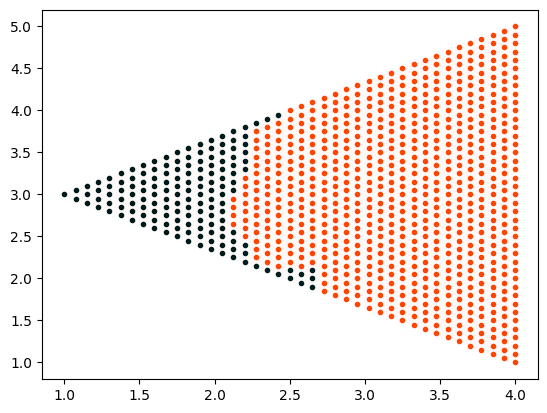

In [8]:
X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()

triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
box_grid_size = 40
max_box_power = 50

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_L(1,0,1,1)
#W_BS09 = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
W_random = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)

for i in range(box_grid_size+1):
    for j in range(box_grid_size-i+1):
        alpha = i/box_grid_size
        beta = j/box_grid_size
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        # Given a box P, we look for the W maximizing P x_W P
        W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
        list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        print(value)
        
        Q=torch.clone(P)
        Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 
        for k in range(max_box_power+1):
            if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                break
            #Q2=Q.copy()
            Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()

In [ ]:
# sauvegarde

X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

# constants
threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
box_grid_size = 10
max_box_power = 10
max_box_power_GD = 5
learning_rate=2
nb_iterations=20

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_1
n = non_local_boxes.evaluate.nb_columns
# W_random = non_local_boxes.utils.random_wiring(n)

for i in range(box_grid_size+1):
    for j in range(box_grid_size-i+1):
        alpha = i/box_grid_size
        beta = j/box_grid_size
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        
        value = float(non_local_boxes.evaluate.h_flat(non_local_boxes.utils.matrix_to_tensor(P)))
        color_point = new_color(value, threshold, 0)

        Q=torch.clone(P)
        Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 
        best_wiring = non_local_boxes.utils.random_wiring(n)

        for k in range(max_box_power-1):
            Q, best_wiring, color_point = next_Q(Q, best_wiring, color_point, k+1, learning_rate, nb_iterations)
            # Tester les puissances au-dessus
        
        # Q2, best_wiring, color_point = next_Q(non_local_boxes.utils.matrix_to_tensor(P), W_random, color_point)
        # Q3, best_wiring, color_point = next_Q(Q2, best_wiring, color_point)
        # Q4, best_wiring, color_point = next_Q(Q3, best_wiring, color_point)
        # Q5, best_wiring, color_point = next_Q(Q4, best_wiring, color_point)

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()